In [29]:
%pip install chardet
%pip install matplotlib
%pip install numpy
%pip install pandas
%pip install scipy


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [30]:
import chardet
import datetime
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import scipy.stats as stats

In [31]:
# Data files:
ROOT_DIR = pathlib.Path(os.getcwd())
DATA_DIR = ROOT_DIR / "data"

# Process PHS Seven Day Average Data

In [32]:
# Data files:
AVG_DATA_FILE = DATA_DIR / "PHS_Wastewater" / "Seven day average of wastewater sample (Retrieved 2024-09-05).csv"


In [33]:
# Determine the encoding of the input file:
with open(AVG_DATA_FILE, 'rb') as data:
    AVG_DATA_ENCODING = chardet.detect(data.read())['encoding']

In [34]:
# Read the data:
AVG_DATA = pd.read_csv(AVG_DATA_FILE, encoding=AVG_DATA_ENCODING, sep=',')

# Process SEPA RNA Monitoring Data

In [35]:
# Data files:
RNA_DATA_FILE = DATA_DIR / "RNAMonitoring_Public" / "RNAMonitoring_Public - Result Description - N1 Gene, Reported Value - N1 Gene (gc-l), Days Since (Retrieved 2024-09-05).csv"

In [36]:
# Determine the encoding of the input file:
with open(RNA_DATA_FILE, 'rb') as data:
    RNA_DATA_ENCODING = chardet.detect(data.read())['encoding']

In [37]:
# Read the data:
rna_data = pd.read_csv(RNA_DATA_FILE, encoding=RNA_DATA_ENCODING, sep='\t')

In [38]:
# Column names:
HEALTH_AREA = 'Health Area'
SITE_NAME = 'Site Name'
POPULATION_SIZE = 'Population'
DATE = 'Date'
VALUE = 'Reported Value - N1 Gene (gc/l)'
VALUE_PER_1000 = 'Reported Value - N1 Gene per 1000 People (gc/l)'
VALUE_PER_PERSON = 'Reported Value - N1 Gene per person (gc/l)'

# Column values:
SITE_NAMES = rna_data[SITE_NAME].unique()
HEALTH_AREA_GGC = 'Greater Glasgow and Clyde'

# Outliers - number of standard deviations:
OUTLIER_STD_DEV = 3

In [39]:
# Check that each sample was taken on a different date:
for site_name in SITE_NAMES:
    assert rna_data[rna_data[SITE_NAME] == site_name][DATE].is_unique

In [40]:
# Remove outliers:
rna_data = rna_data[np.abs(stats.zscore(rna_data[VALUE])) < OUTLIER_STD_DEV]

In [41]:
# Remove samples without specified population:
rna_data = rna_data[rna_data[POPULATION_SIZE] != '(Empty)']

In [42]:
# Convert the date:
def parse_datetime(date):
    if not isinstance(date, datetime.datetime):
        month, day, year = map(int, date.split("/"))
        return datetime.datetime(year, month, day)
    else:
        return date

# Create a datetime index:
rna_data[DATE] = pd.DatetimeIndex(rna_data[DATE].map(parse_datetime))

In [43]:
# Convert the population size:
def parse_population_size(population_size):
    try:
        return float(population_size)
    except ValueError:
        return None

# Add value per person:
rna_data[VALUE_PER_PERSON] = rna_data[VALUE] / rna_data[POPULATION_SIZE].map(parse_population_size)

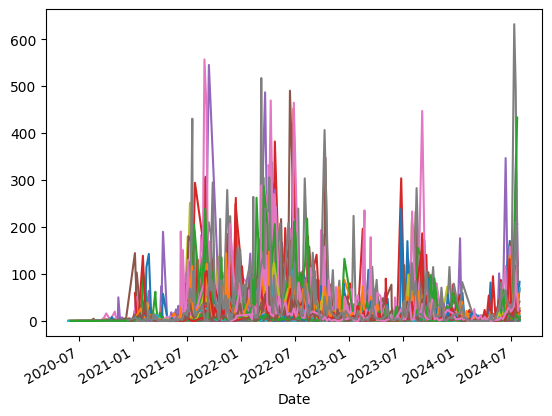

In [47]:
# Plot the value per person for each monitorint site:
_ = rna_data.groupby(SITE_NAME).apply(lambda df_sn: df_sn.set_index(DATE)[VALUE_PER_PERSON].plot(), include_groups=False)